In [104]:
import torch
import json
import h5py
import random
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw, ImageFont

In [110]:
# load the following to files from DETECTED_SGG_DIR
# custom_prediction = json.load(open('/ho|me/kaihua/checkpoints/test/custom_prediction.json'))

custom_prediction = json.load(open('/hdd/skchoi/SGG_from_NLS/visualization/custom_prediction.json'))
# custom_data_info = json.load(open('/home/kaihua/checkpoints/test/custom_data_info.json'))

In [111]:
def draw_single_box(pic, box, j, color='red', draw_info=None):
    font_size = 15
    # font = ImageFont.truetype(font_size)
    print("draw info: ", draw_info)
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2])+((j+1)*100), int(box[3])

    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y1), (x1+50, y1+10)), fill=color)
        info = draw_info
        draw.text((x1, y1), info)
        
def print_list(name, input_list, scores=None):
    for i, item in enumerate(input_list):
        if scores == None:
            print(name + ' ' + str(i) + ': ' + str(item))
        else:
            print(name + ' ' + str(i) + ': ' + str(item) + '; score: ' + str(scores[i]))
    
def draw_image(img_path, boxes, box_labels, rel_labels, box_scores=None, rel_scores=None):
    
    size = get_size(Image.open(img_path).size)
    pic = Image.open(img_path).resize(size)
    num_obj = len(boxes)
    for i in range(num_obj):
        info = str(i) + '_' + box_labels[i]
        draw_single_box(pic, boxes[i], i, draw_info=info)
    display(pic)
    
    print('*' * 50)
    print_list('box_labels', box_labels, box_scores)
    print('*' * 50)
    print_list('rel_labels', rel_labels, rel_scores)
    
    return None

def get_size(image_size):
    min_size = 600
    max_size = 1000
    w, h = image_size
    size = min_size
    if max_size is not None:
        min_original_size = float(min((w, h)))
        max_original_size = float(max((w, h)))
        if max_original_size / min_original_size * size > max_size:
            size = int(round(max_size * min_original_size / max_original_size))
    if (w <= h and w == size) or (h <= w and h == size):
        return (w, h)
    if w < h:
        ow = size
        oh = int(size * h / w)
    else:
        oh = size
        ow = int(size * w / h)
    return (ow, oh)

In [112]:
# parameters
image_idx = 0
box_topk = 20 # select top k bounding boxes
rel_topk = 20 # select top k relationships
# ind_to_classes = custom_data_info['ind_to_classes']
# ind_to_predicates = custom_data_info['ind_to_predicates']

project_dir = '/hdd/skchoi/SGG_from_NLS/'
vocab_file = json.load(open(f'{project_dir}/datasets/vg/VG-SGG-dicts-with-attri.json'))
ind_to_predicates = vocab_file['idx_to_predicate']
ind_to_classes = vocab_file['idx_to_label']

print(len(ind_to_predicates), len(ind_to_classes))

50 150


In [113]:
ind_to_classes

{'1': 'airplane',
 '2': 'animal',
 '3': 'arm',
 '4': 'bag',
 '5': 'banana',
 '6': 'basket',
 '7': 'beach',
 '8': 'bear',
 '9': 'bed',
 '10': 'bench',
 '11': 'bike',
 '12': 'bird',
 '13': 'board',
 '14': 'boat',
 '15': 'book',
 '16': 'boot',
 '17': 'bottle',
 '18': 'bowl',
 '19': 'box',
 '20': 'boy',
 '21': 'branch',
 '22': 'building',
 '23': 'bus',
 '24': 'cabinet',
 '25': 'cap',
 '26': 'car',
 '27': 'cat',
 '28': 'chair',
 '29': 'child',
 '30': 'clock',
 '31': 'coat',
 '32': 'counter',
 '33': 'cow',
 '34': 'cup',
 '35': 'curtain',
 '36': 'desk',
 '37': 'dog',
 '38': 'door',
 '39': 'drawer',
 '40': 'ear',
 '41': 'elephant',
 '42': 'engine',
 '43': 'eye',
 '44': 'face',
 '45': 'fence',
 '46': 'finger',
 '47': 'flag',
 '48': 'flower',
 '49': 'food',
 '50': 'fork',
 '51': 'fruit',
 '52': 'giraffe',
 '53': 'girl',
 '54': 'glass',
 '55': 'glove',
 '56': 'guy',
 '57': 'hair',
 '58': 'hand',
 '59': 'handle',
 '60': 'hat',
 '61': 'head',
 '62': 'helmet',
 '63': 'hill',
 '64': 'horse',
 '65': '

In [101]:
!!pip install pycocotools

['Requirement already satisfied: pycocotools in /home/skchoi/.conda/envs/sgb_n/lib/python3.7/site-packages/pycocotools-2.0-py3.7-linux-x86_64.egg (2.0)',
 'Requirement already satisfied: setuptools>=18.0 in /home/skchoi/.local/lib/python3.7/site-packages (from pycocotools) (65.6.3)',
 'Requirement already satisfied: cython>=0.27.3 in /home/skchoi/.conda/envs/sgb_n/lib/python3.7/site-packages (from pycocotools) (0.29.32)',
 'Requirement already satisfied: matplotlib>=2.1.0 in /home/skchoi/.conda/envs/sgb_n/lib/python3.7/site-packages (from pycocotools) (3.5.3)',
 'Requirement already satisfied: python-dateutil>=2.7 in /home/skchoi/.local/lib/python3.7/site-packages (from matplotlib>=2.1.0->pycocotools) (2.8.2)',
 'Requirement already satisfied: numpy>=1.17 in /home/skchoi/.conda/envs/sgb_n/lib/python3.7/site-packages (from matplotlib>=2.1.0->pycocotools) (1.21.5)',
 'Requirement already satisfied: pillow>=6.2.0 in /home/skchoi/.conda/envs/sgb_n/lib/python3.7/site-packages (from matplotl

In [107]:
import os
import pathlib

PATH_TO_TEST_IMAGES_DIR = pathlib.Path("/hdd/skchoi/SGG_from_NLS/datasets/vg/VG_10")
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))

---aa.jpg------
==>  [18.0, 34.0, 18.0]
in
in
in
with
with
of
draw info:  0_bowl
draw info:  1_cup
draw info:  2_bowl


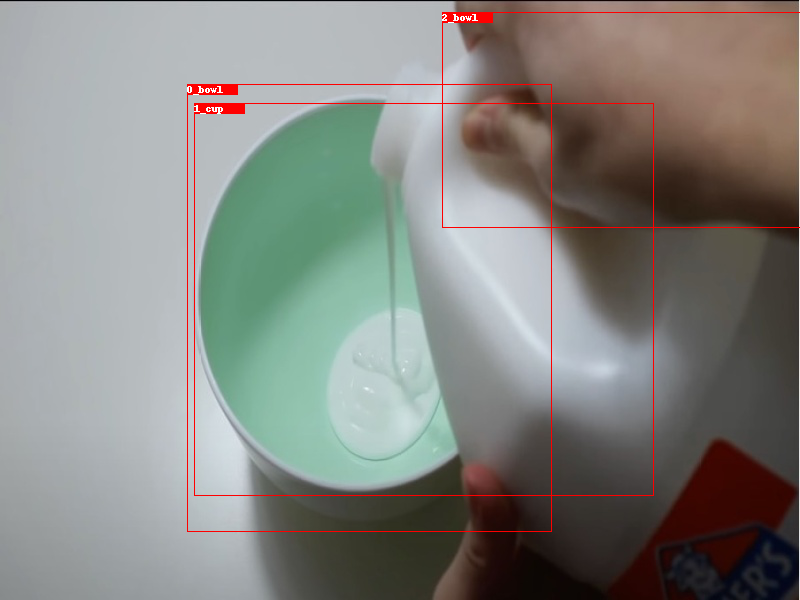

**************************************************
box_labels 0: bowl; score: 0.14892578125
box_labels 1: cup; score: 0.0083770751953125
box_labels 2: bowl; score: 0.0014286041259765625
**************************************************
rel_labels 0: 2_bowl => in => 0_bowl; score: 0.11090087890625
rel_labels 1: 1_cup => in => 0_bowl; score: 0.0693359375
rel_labels 2: 2_bowl => in => 1_cup; score: 0.031402587890625
rel_labels 3: 0_bowl => with => 1_cup; score: 0.027099609375
rel_labels 4: 0_bowl => with => 2_bowl; score: 0.0169219970703125
rel_labels 5: 1_cup => of => 2_bowl; score: 0.01433563232421875
---bb.jpg------
==>  [58.0, 50.0, 18.0]
with
in
holding
holding
with
with
draw info:  0_hand
draw info:  1_fork
draw info:  2_bowl


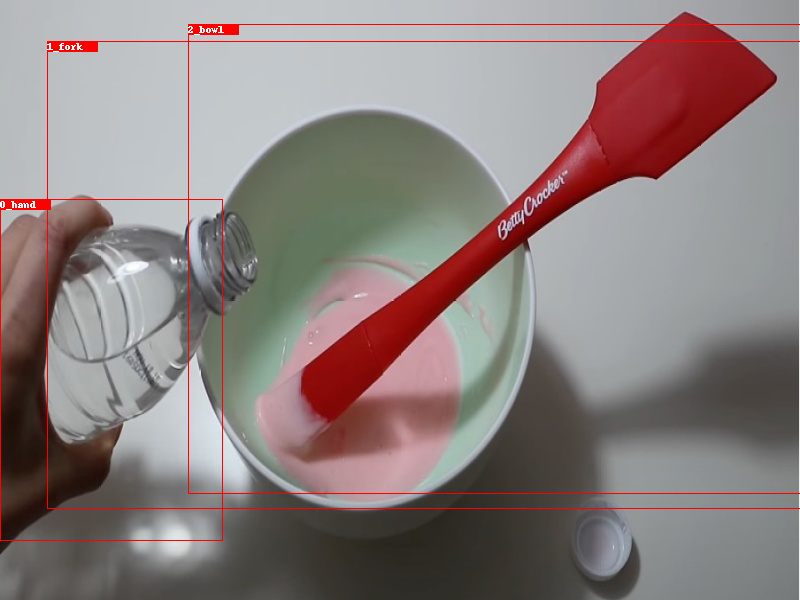

**************************************************
box_labels 0: hand; score: 0.016632080078125
box_labels 1: fork; score: 0.01447296142578125
box_labels 2: bowl; score: 0.01016998291015625
**************************************************
rel_labels 0: 1_fork => with => 2_bowl; score: 0.1739501953125
rel_labels 1: 1_fork => in => 0_hand; score: 0.16455078125
rel_labels 2: 0_hand => holding => 2_bowl; score: 0.080810546875
rel_labels 3: 0_hand => holding => 1_fork; score: 0.07965087890625
rel_labels 4: 2_bowl => with => 0_hand; score: 0.07025146484375
rel_labels 5: 2_bowl => with => 1_fork; score: 0.066650390625
---cc.jpg------
==>  [91.0, 58.0, 58.0, 58.0]
in
holding
in
holding
with
with
of
holding
in
in
holding
holding
draw info:  0_person
draw info:  1_hand
draw info:  2_hand
draw info:  3_hand


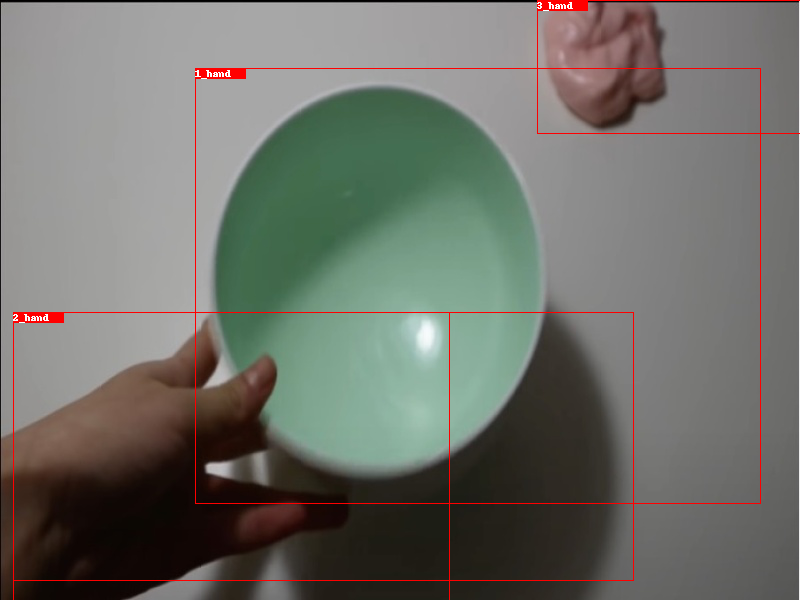

**************************************************
box_labels 0: person; score: 0.456787109375
box_labels 1: hand; score: 0.079833984375
box_labels 2: hand; score: 0.041015625
box_labels 3: hand; score: 0.0079345703125
**************************************************
rel_labels 0: 0_person => in => 2_hand; score: 0.2734375
rel_labels 1: 0_person => holding => 1_hand; score: 0.158447265625
rel_labels 2: 0_person => in => 3_hand; score: 0.086181640625
rel_labels 3: 2_hand => holding => 1_hand; score: 0.07586669921875
rel_labels 4: 1_hand => with => 2_hand; score: 0.04425048828125
rel_labels 5: 1_hand => with => 3_hand; score: 0.03485107421875
rel_labels 6: 1_hand => of => 0_person; score: 0.032989501953125
rel_labels 7: 3_hand => holding => 1_hand; score: 0.0278167724609375
rel_labels 8: 2_hand => in => 3_hand; score: 0.00753021240234375
rel_labels 9: 3_hand => in => 2_hand; score: 0.006702423095703125
rel_labels 10: 2_hand => holding => 0_person; score: 0.0038547515869140625
rel_label

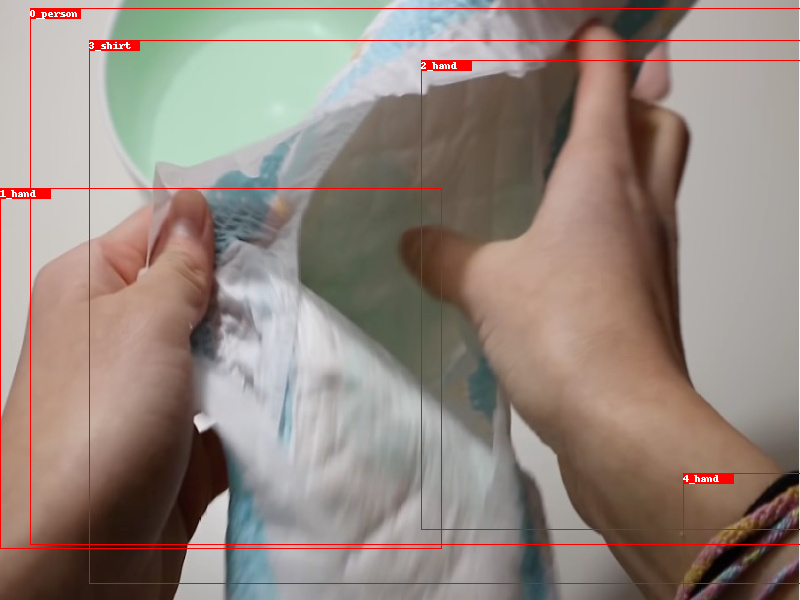

**************************************************
box_labels 0: person; score: 0.6240234375
box_labels 1: hand; score: 0.48779296875
box_labels 2: hand; score: 0.30517578125
box_labels 3: shirt; score: 0.0968017578125
box_labels 4: hand; score: 0.0009598731994628906
**************************************************
rel_labels 0: 0_person => in => 3_shirt; score: 0.5166015625
rel_labels 1: 0_person => in => 1_hand; score: 0.38134765625
rel_labels 2: 0_person => in => 2_hand; score: 0.351318359375
rel_labels 3: 0_person => with => 4_hand; score: 0.2025146484375
rel_labels 4: 1_hand => holding => 4_hand; score: 0.05914306640625
rel_labels 5: 4_hand => in => 1_hand; score: 0.054443359375
rel_labels 6: 4_hand => in => 2_hand; score: 0.049072265625
rel_labels 7: 2_hand => holding => 4_hand; score: 0.033905029296875
rel_labels 8: 3_shirt => in => 1_hand; score: 0.032745361328125
rel_labels 9: 3_shirt => in => 2_hand; score: 0.0299530029296875
rel_labels 10: 1_hand => in => 3_shirt; score: 0

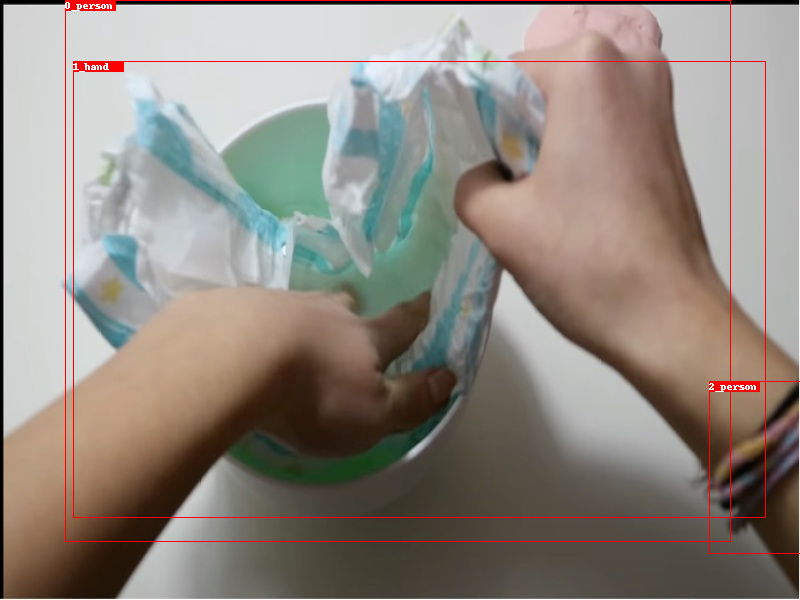

**************************************************
box_labels 0: person; score: 0.73291015625
box_labels 1: hand; score: 0.284423828125
box_labels 2: person; score: 0.0016870498657226562
**************************************************
rel_labels 0: 0_person => holding => 1_hand; score: 0.423583984375
rel_labels 1: 0_person => holding => 2_person; score: 0.1937255859375
rel_labels 2: 1_hand => with => 2_person; score: 0.049072265625
rel_labels 3: 2_person => in => 1_hand; score: 0.007781982421875
rel_labels 4: 1_hand => of => 0_person; score: 0.00222015380859375
rel_labels 5: 2_person => with => 0_person; score: 0.0002887248992919922
---ff.jpg------
==>  [91.0, 91.0, 111.0, 66.0]
in
in
in
in
holding
holding
holding
holding
wearing
wearing
holding
holding
draw info:  0_person
draw info:  1_person
draw info:  2_shirt
draw info:  3_jacket


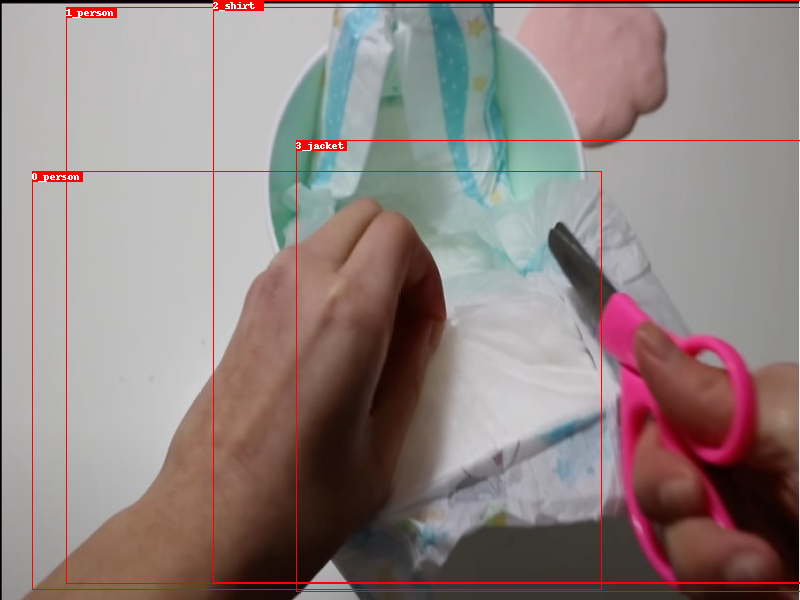

**************************************************
box_labels 0: person; score: 0.5205078125
box_labels 1: person; score: 0.5078125
box_labels 2: shirt; score: 0.328125
box_labels 3: jacket; score: 0.06591796875
**************************************************
rel_labels 0: 1_person => in => 2_shirt; score: 0.452392578125
rel_labels 1: 1_person => in => 3_jacket; score: 0.44970703125
rel_labels 2: 0_person => in => 3_jacket; score: 0.415771484375
rel_labels 3: 0_person => in => 2_shirt; score: 0.413818359375
rel_labels 4: 0_person => holding => 1_person; score: 0.0308685302734375
rel_labels 5: 1_person => holding => 0_person; score: 0.0276947021484375
rel_labels 6: 2_shirt => holding => 1_person; score: 0.004772186279296875
rel_labels 7: 2_shirt => holding => 0_person; score: 0.003391265869140625
rel_labels 8: 2_shirt => wearing => 3_jacket; score: 0.00327301025390625
rel_labels 9: 3_jacket => wearing => 2_shirt; score: 0.003025054931640625
rel_labels 10: 3_jacket => holding => 1_per

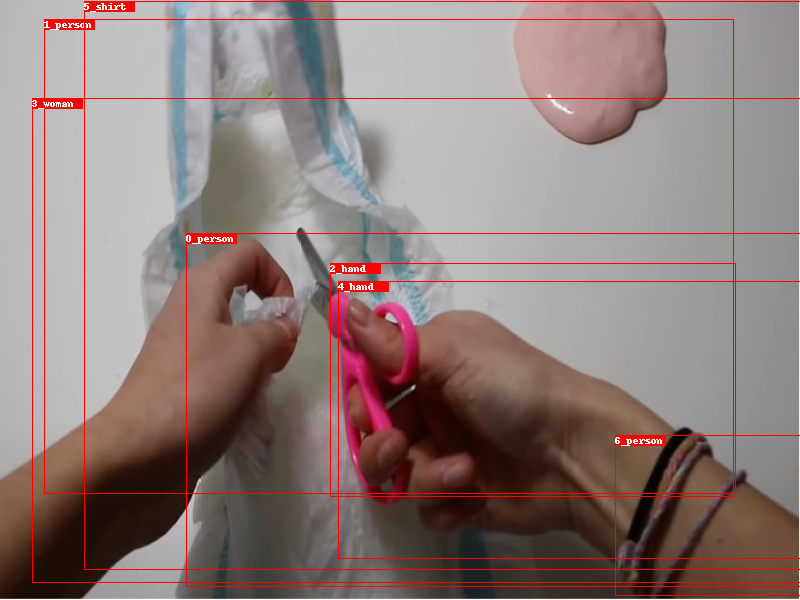

**************************************************
box_labels 0: person; score: 0.54833984375
box_labels 1: person; score: 0.493896484375
box_labels 2: hand; score: 0.4912109375
box_labels 3: woman; score: 0.2529296875
box_labels 4: hand; score: 0.2083740234375
box_labels 5: shirt; score: 0.2034912109375
box_labels 6: person; score: 0.001739501953125
**************************************************
rel_labels 0: 0_person => in => 5_shirt; score: 0.410400390625
rel_labels 1: 1_person => in => 5_shirt; score: 0.38818359375
rel_labels 2: 3_woman => in => 5_shirt; score: 0.386962890625
rel_labels 3: 3_woman => in => 4_hand; score: 0.3125
rel_labels 4: 0_person => in => 4_hand; score: 0.308349609375
rel_labels 5: 1_person => in => 4_hand; score: 0.279052734375
rel_labels 6: 3_woman => in => 2_hand; score: 0.27587890625
rel_labels 7: 0_person => in => 2_hand; score: 0.2705078125
rel_labels 8: 1_person => in => 2_hand; score: 0.26806640625
rel_labels 9: 3_woman => holding => 6_person; score

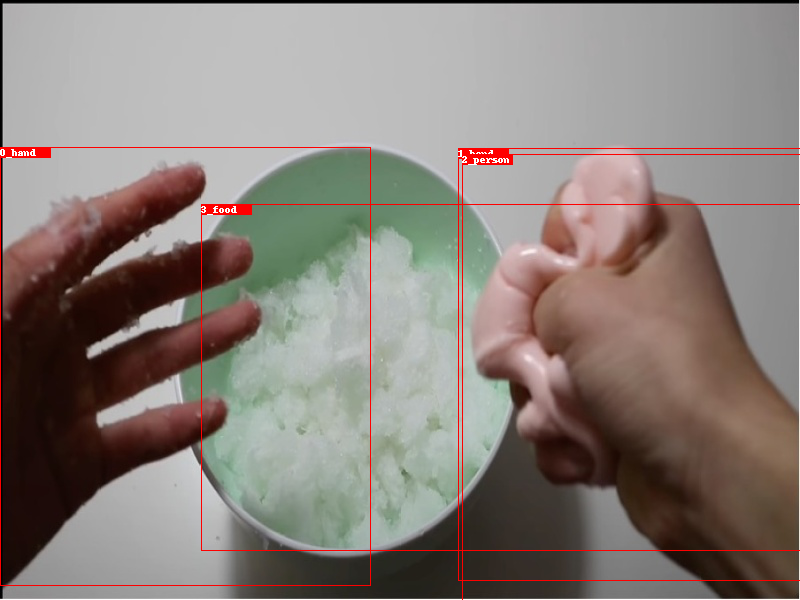

**************************************************
box_labels 0: hand; score: 0.88037109375
box_labels 1: hand; score: 0.8662109375
box_labels 2: person; score: 0.75634765625
box_labels 3: food; score: 0.07965087890625
**************************************************
rel_labels 0: 0_hand => holding => 3_food; score: 0.376220703125
rel_labels 1: 1_hand => holding => 3_food; score: 0.322509765625
rel_labels 2: 2_person => holding => 3_food; score: 0.2213134765625
rel_labels 3: 2_person => in => 0_hand; score: 0.2178955078125
rel_labels 4: 2_person => in => 1_hand; score: 0.20556640625
rel_labels 5: 3_food => in => 0_hand; score: 0.0648193359375
rel_labels 6: 3_food => in => 1_hand; score: 0.0570068359375
rel_labels 7: 1_hand => holding => 2_person; score: 0.02252197265625
rel_labels 8: 0_hand => holding => 2_person; score: 0.0184783935546875
rel_labels 9: 0_hand => in => 1_hand; score: 0.0097808837890625
rel_labels 10: 1_hand => in => 0_hand; score: 0.00959014892578125
rel_labels 11: 3

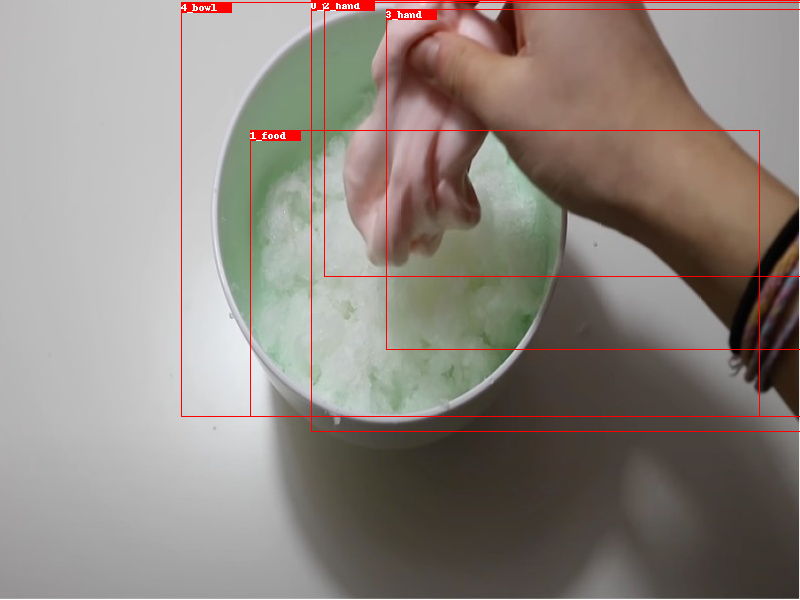

**************************************************
box_labels 0: person; score: 0.6416015625
box_labels 1: food; score: 0.55224609375
box_labels 2: hand; score: 0.37890625
box_labels 3: hand; score: 0.296630859375
box_labels 4: bowl; score: 0.1944580078125
**************************************************
rel_labels 0: 4_bowl => of => 1_food; score: 0.4306640625
rel_labels 1: 0_person => in => 3_hand; score: 0.2421875
rel_labels 2: 0_person => in => 2_hand; score: 0.1875
rel_labels 3: 0_person => in => 4_bowl; score: 0.1580810546875
rel_labels 4: 2_hand => holding => 4_bowl; score: 0.142578125
rel_labels 5: 3_hand => holding => 4_bowl; score: 0.11968994140625
rel_labels 6: 3_hand => holding => 1_food; score: 0.10308837890625
rel_labels 7: 1_food => in => 4_bowl; score: 0.061309814453125
rel_labels 8: 1_food => in => 3_hand; score: 0.05267333984375
rel_labels 9: 0_person => with => 1_food; score: 0.051513671875
rel_labels 10: 1_food => in => 2_hand; score: 0.031646728515625
rel_labels 

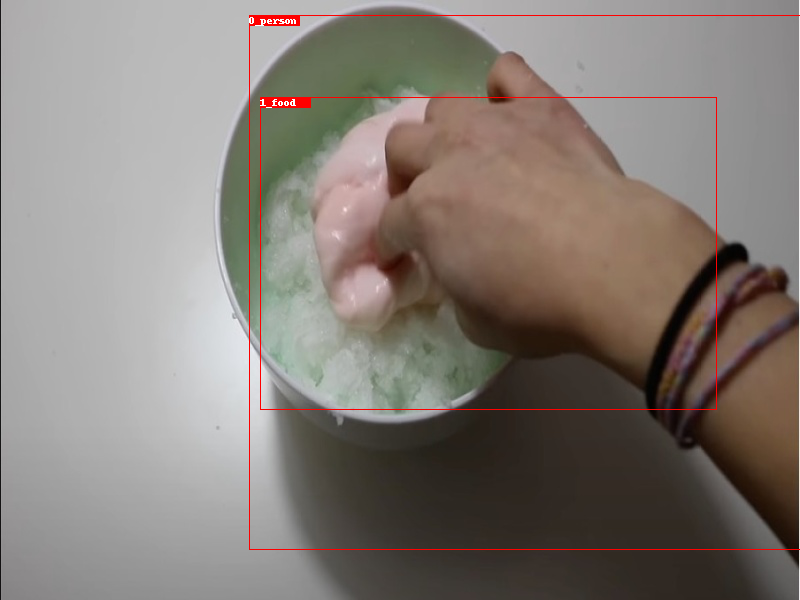

**************************************************
box_labels 0: person; score: 0.6240234375
box_labels 1: food; score: 0.330810546875
**************************************************
rel_labels 0: 0_person => holding => 1_food; score: 0.17626953125
rel_labels 1: 1_food => with => 0_person; score: 0.0023441314697265625
---kk.jpg------
==>  [91.0, 49.0, 49.0, 91.0, 3.0, 49.0]
with
with
holding
with
holding
of
of
with
of
of
of
on
of
with
in
with
with
of
of
on
with
in
in
with
with
with
with
in
with
with
draw info:  0_person
draw info:  1_food
draw info:  2_food
draw info:  3_person
draw info:  4_arm
draw info:  5_food


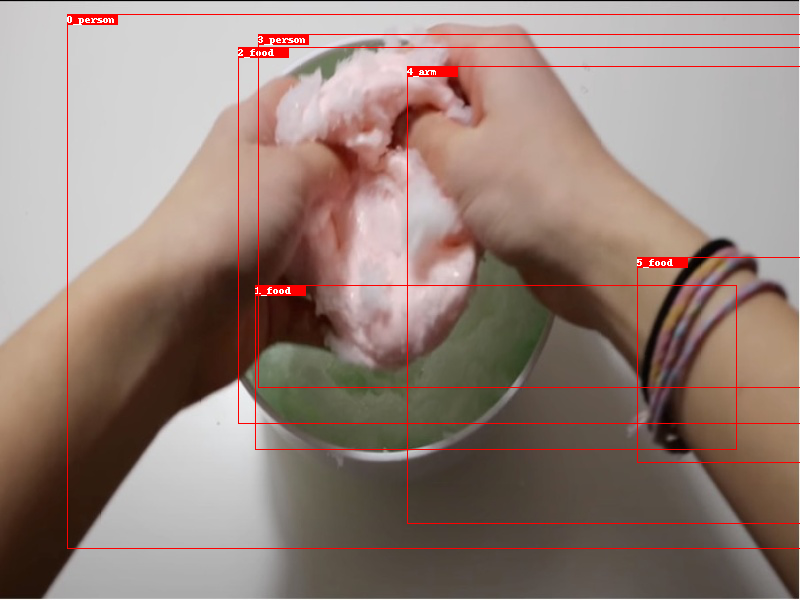

**************************************************
box_labels 0: person; score: 0.72314453125
box_labels 1: food; score: 0.482177734375
box_labels 2: food; score: 0.164306640625
box_labels 3: person; score: 0.0130157470703125
box_labels 4: arm; score: 0.0117645263671875
box_labels 5: food; score: 0.0025634765625
**************************************************
rel_labels 0: 0_person => with => 3_person; score: 0.2103271484375
rel_labels 1: 0_person => with => 4_arm; score: 0.1917724609375
rel_labels 2: 0_person => holding => 2_food; score: 0.1671142578125
rel_labels 3: 0_person => with => 5_food; score: 0.11993408203125
rel_labels 4: 0_person => holding => 1_food; score: 0.10894775390625
rel_labels 5: 4_arm => of => 1_food; score: 0.0882568359375
rel_labels 6: 4_arm => of => 3_person; score: 0.087646484375
rel_labels 7: 2_food => with => 3_person; score: 0.058624267578125
rel_labels 8: 4_arm => of => 2_food; score: 0.049163818359375
rel_labels 9: 3_person => of => 1_food; score: 0.04

In [114]:
# img_paths =['l.jpg', 'k.jpg', 'j.jpg','i.jpg', 'h.jpg','g.jpg', 'f.jpg','e.jpg', 'd.jpg', 'c.jpg', 'b.jpg']#, 'g.jpg', 'h.jpg', 'i.jpg', 'j.jpg']
for image_idx, each_img_path in enumerate(TEST_IMAGE_PATHS):
    image_path = str(each_img_path)
    each_img = image_path.split('/')[-1]
    print("---{}------".format(each_img))
    image_path = "/hdd/skchoi/SGG_from_NLS/datasets/vg/VG_10/{}".format(each_img)
    boxes = custom_prediction[str(image_idx)]['bbox'][:box_topk]
    box_labels = custom_prediction[str(image_idx)]['bbox_labels'][:box_topk]
    box_scores = custom_prediction[str(image_idx)]['bbox_scores'][:box_topk]
    all_rel_labels = custom_prediction[str(image_idx)]['rel_labels']
    all_rel_scores = custom_prediction[str(image_idx)]['rel_scores']
    all_rel_pairs = custom_prediction[str(image_idx)]['rel_pairs']

    print("==> ", box_labels)
    for i in range(len(box_labels)):
        # print
        # print(type(box_labels[i]), box_labels[i])
        idx = str(int(box_labels[i]))
        box_labels[i] = ind_to_classes[idx]

    rel_labels = []
    rel_scores = []
    for i in range(len(all_rel_pairs)):
        if all_rel_pairs[i][0] < box_topk and all_rel_pairs[i][1] < box_topk:
            rel_scores.append(all_rel_scores[i])
            print(ind_to_predicates[str(all_rel_labels[i])] )#+ ' => ' + str(all_rel_pairs[i][1]) + '_' + box_labels[all_rel_pairs[i][1]])
            label = str(all_rel_pairs[i]
            [0]) + '_' + box_labels[all_rel_pairs[i][0]] + ' => ' + ind_to_predicates[str(all_rel_labels[i])]  + ' => ' + str(all_rel_pairs[i][1]) + '_' + box_labels[all_rel_pairs[i][1]]
            # label = box_labels[all_rel_pairs[i][0]] + ' => ' + ind_to_predicates[str(all_rel_labels[i])]  + ' => ' + box_labels[all_rel_pairs[i][1]]
            rel_labels.append(label)

    rel_labels = rel_labels[:rel_topk]
    rel_scores = rel_scores[:rel_topk]

    draw_image(image_path, boxes, box_labels, rel_labels, box_scores=box_scores, rel_scores=rel_scores)

---aa.jpg------
==>  [18.0, 34.0, 18.0]
in
in
in
with
with
of
draw info:  0_bowl
draw info:  1_cup
draw info:  2_bowl


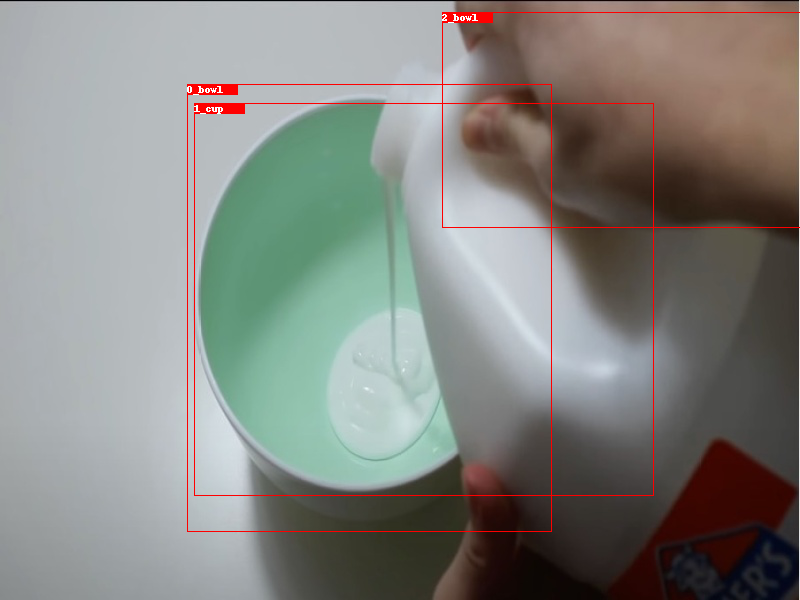

**************************************************
box_labels 0: bowl; score: 0.14892578125
box_labels 1: cup; score: 0.0083770751953125
box_labels 2: bowl; score: 0.0014286041259765625
**************************************************
rel_labels 0: 2_bowl => in => 0_bowl; score: 0.11090087890625
rel_labels 1: 1_cup => in => 0_bowl; score: 0.0693359375
rel_labels 2: 2_bowl => in => 1_cup; score: 0.031402587890625
rel_labels 3: 0_bowl => with => 1_cup; score: 0.027099609375
rel_labels 4: 0_bowl => with => 2_bowl; score: 0.0169219970703125
rel_labels 5: 1_cup => of => 2_bowl; score: 0.01433563232421875
---bb.jpg------
==>  [58.0, 50.0, 18.0]
with
in
holding
holding
with
with
draw info:  0_hand
draw info:  1_fork
draw info:  2_bowl


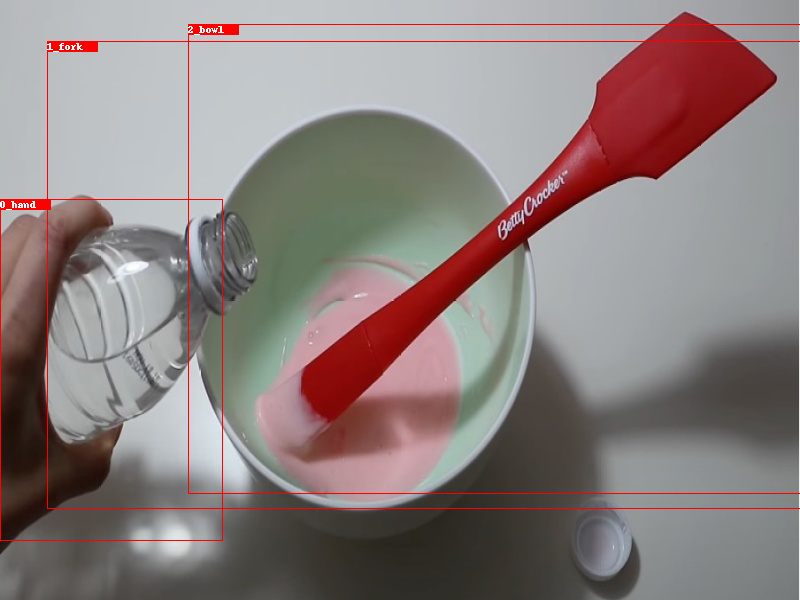

**************************************************
box_labels 0: hand; score: 0.016632080078125
box_labels 1: fork; score: 0.01447296142578125
box_labels 2: bowl; score: 0.01016998291015625
**************************************************
rel_labels 0: 1_fork => with => 2_bowl; score: 0.1739501953125
rel_labels 1: 1_fork => in => 0_hand; score: 0.16455078125
rel_labels 2: 0_hand => holding => 2_bowl; score: 0.080810546875
rel_labels 3: 0_hand => holding => 1_fork; score: 0.07965087890625
rel_labels 4: 2_bowl => with => 0_hand; score: 0.07025146484375
rel_labels 5: 2_bowl => with => 1_fork; score: 0.066650390625
---cc.jpg------
==>  [91.0, 58.0, 58.0, 58.0]
in
holding
in
holding
with
with
of
holding
in
in
holding
holding
draw info:  0_person
draw info:  1_hand
draw info:  2_hand
draw info:  3_hand


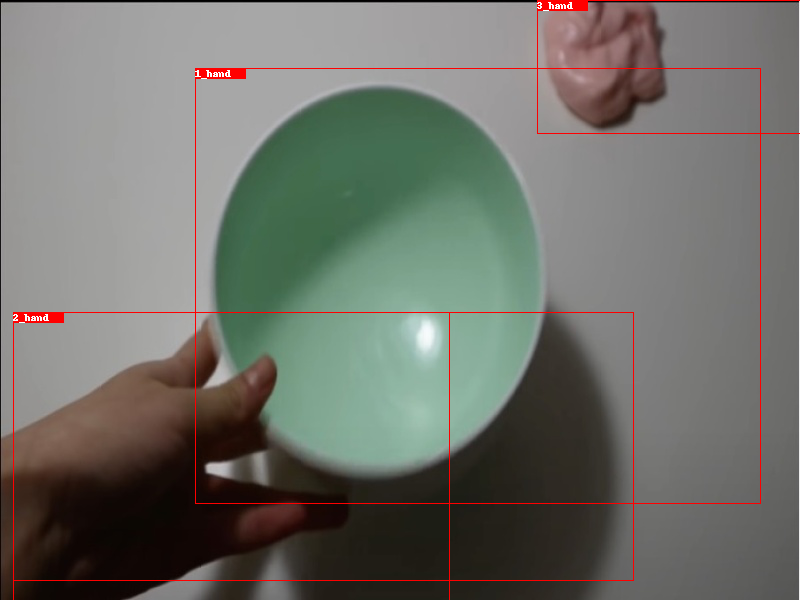

**************************************************
box_labels 0: person; score: 0.456787109375
box_labels 1: hand; score: 0.079833984375
box_labels 2: hand; score: 0.041015625
box_labels 3: hand; score: 0.0079345703125
**************************************************
rel_labels 0: 0_person => in => 2_hand; score: 0.2734375
rel_labels 1: 0_person => holding => 1_hand; score: 0.158447265625
rel_labels 2: 0_person => in => 3_hand; score: 0.086181640625
rel_labels 3: 2_hand => holding => 1_hand; score: 0.07586669921875
rel_labels 4: 1_hand => with => 2_hand; score: 0.04425048828125
rel_labels 5: 1_hand => with => 3_hand; score: 0.03485107421875
rel_labels 6: 1_hand => of => 0_person; score: 0.032989501953125
rel_labels 7: 3_hand => holding => 1_hand; score: 0.0278167724609375
rel_labels 8: 2_hand => in => 3_hand; score: 0.00753021240234375
rel_labels 9: 3_hand => in => 2_hand; score: 0.006702423095703125
rel_labels 10: 2_hand => holding => 0_person; score: 0.0038547515869140625
rel_label

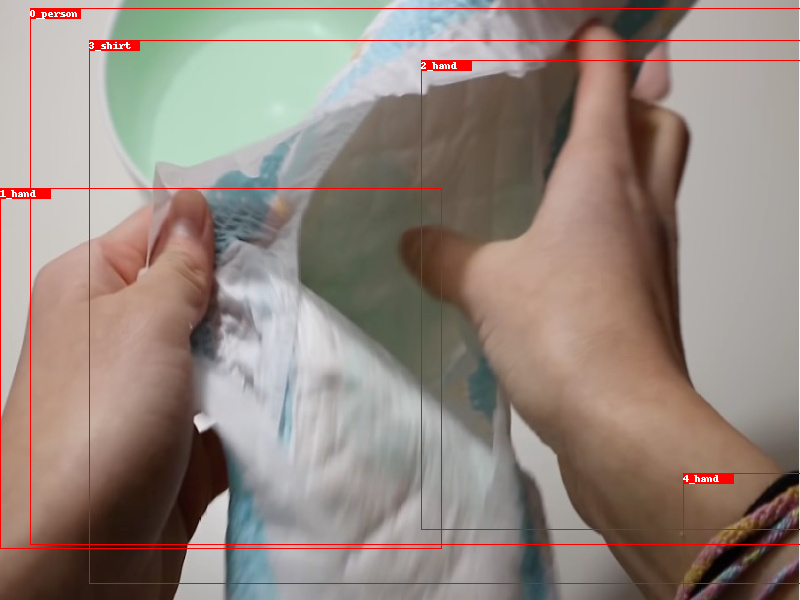

**************************************************
box_labels 0: person; score: 0.6240234375
box_labels 1: hand; score: 0.48779296875
box_labels 2: hand; score: 0.30517578125
box_labels 3: shirt; score: 0.0968017578125
box_labels 4: hand; score: 0.0009598731994628906
**************************************************
rel_labels 0: 0_person => in => 3_shirt; score: 0.5166015625
rel_labels 1: 0_person => in => 1_hand; score: 0.38134765625
rel_labels 2: 0_person => in => 2_hand; score: 0.351318359375
rel_labels 3: 0_person => with => 4_hand; score: 0.2025146484375
rel_labels 4: 1_hand => holding => 4_hand; score: 0.05914306640625
rel_labels 5: 4_hand => in => 1_hand; score: 0.054443359375
rel_labels 6: 4_hand => in => 2_hand; score: 0.049072265625
rel_labels 7: 2_hand => holding => 4_hand; score: 0.033905029296875
rel_labels 8: 3_shirt => in => 1_hand; score: 0.032745361328125
rel_labels 9: 3_shirt => in => 2_hand; score: 0.0299530029296875
rel_labels 10: 1_hand => in => 3_shirt; score: 0

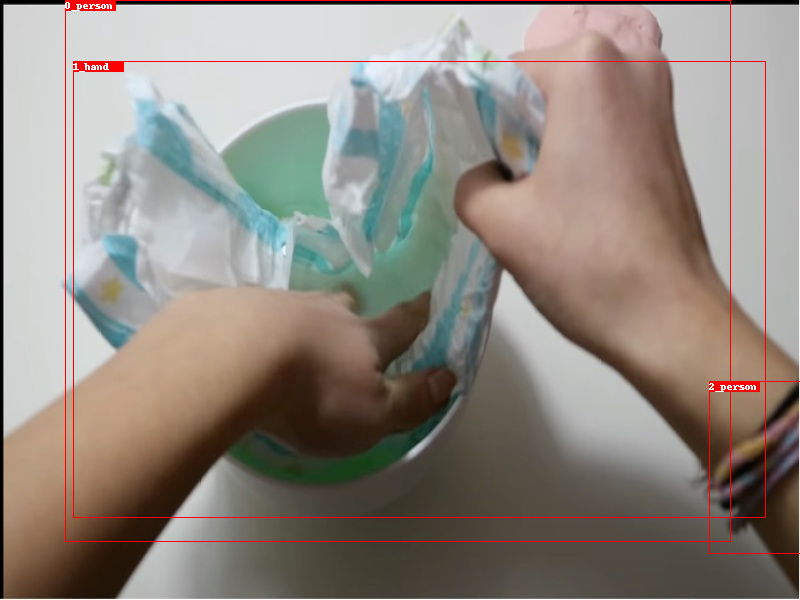

**************************************************
box_labels 0: person; score: 0.73291015625
box_labels 1: hand; score: 0.284423828125
box_labels 2: person; score: 0.0016870498657226562
**************************************************
rel_labels 0: 0_person => holding => 1_hand; score: 0.423583984375
rel_labels 1: 0_person => holding => 2_person; score: 0.1937255859375
rel_labels 2: 1_hand => with => 2_person; score: 0.049072265625
rel_labels 3: 2_person => in => 1_hand; score: 0.007781982421875
rel_labels 4: 1_hand => of => 0_person; score: 0.00222015380859375
rel_labels 5: 2_person => with => 0_person; score: 0.0002887248992919922
---ff.jpg------
==>  [91.0, 91.0, 111.0, 66.0]
in
in
in
in
holding
holding
holding
holding
wearing
wearing
holding
holding
draw info:  0_person
draw info:  1_person
draw info:  2_shirt
draw info:  3_jacket


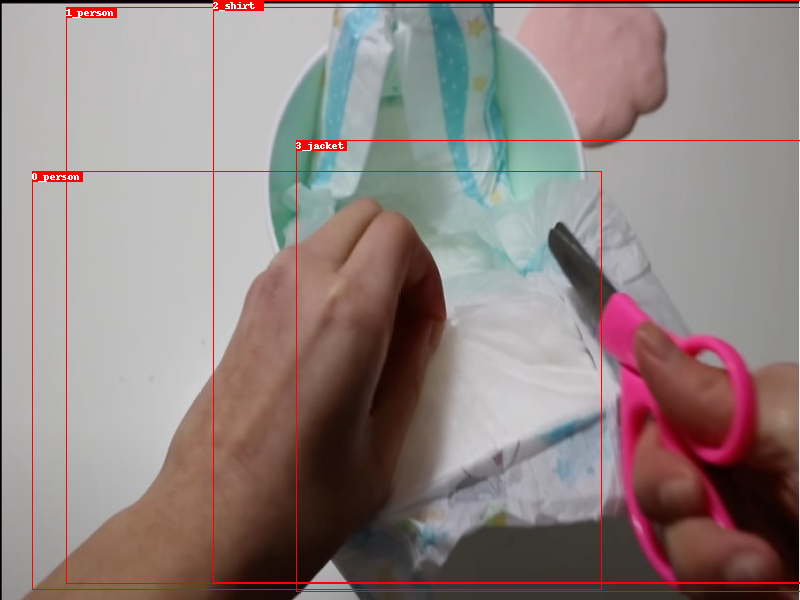

**************************************************
box_labels 0: person; score: 0.5205078125
box_labels 1: person; score: 0.5078125
box_labels 2: shirt; score: 0.328125
box_labels 3: jacket; score: 0.06591796875
**************************************************
rel_labels 0: 1_person => in => 2_shirt; score: 0.452392578125
rel_labels 1: 1_person => in => 3_jacket; score: 0.44970703125
rel_labels 2: 0_person => in => 3_jacket; score: 0.415771484375
rel_labels 3: 0_person => in => 2_shirt; score: 0.413818359375
rel_labels 4: 0_person => holding => 1_person; score: 0.0308685302734375
rel_labels 5: 1_person => holding => 0_person; score: 0.0276947021484375
rel_labels 6: 2_shirt => holding => 1_person; score: 0.004772186279296875
rel_labels 7: 2_shirt => holding => 0_person; score: 0.003391265869140625
rel_labels 8: 2_shirt => wearing => 3_jacket; score: 0.00327301025390625
rel_labels 9: 3_jacket => wearing => 2_shirt; score: 0.003025054931640625
rel_labels 10: 3_jacket => holding => 1_per

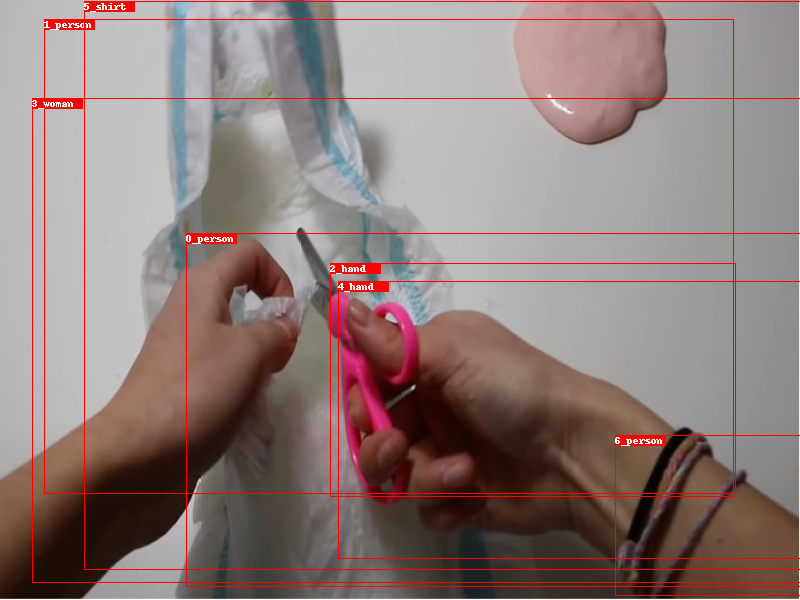

**************************************************
box_labels 0: person; score: 0.54833984375
box_labels 1: person; score: 0.493896484375
box_labels 2: hand; score: 0.4912109375
box_labels 3: woman; score: 0.2529296875
box_labels 4: hand; score: 0.2083740234375
box_labels 5: shirt; score: 0.2034912109375
box_labels 6: person; score: 0.001739501953125
**************************************************
rel_labels 0: 0_person => in => 5_shirt; score: 0.410400390625
rel_labels 1: 1_person => in => 5_shirt; score: 0.38818359375
rel_labels 2: 3_woman => in => 5_shirt; score: 0.386962890625
rel_labels 3: 3_woman => in => 4_hand; score: 0.3125
rel_labels 4: 0_person => in => 4_hand; score: 0.308349609375
rel_labels 5: 1_person => in => 4_hand; score: 0.279052734375
rel_labels 6: 3_woman => in => 2_hand; score: 0.27587890625
rel_labels 7: 0_person => in => 2_hand; score: 0.2705078125
rel_labels 8: 1_person => in => 2_hand; score: 0.26806640625
rel_labels 9: 3_woman => holding => 6_person; score

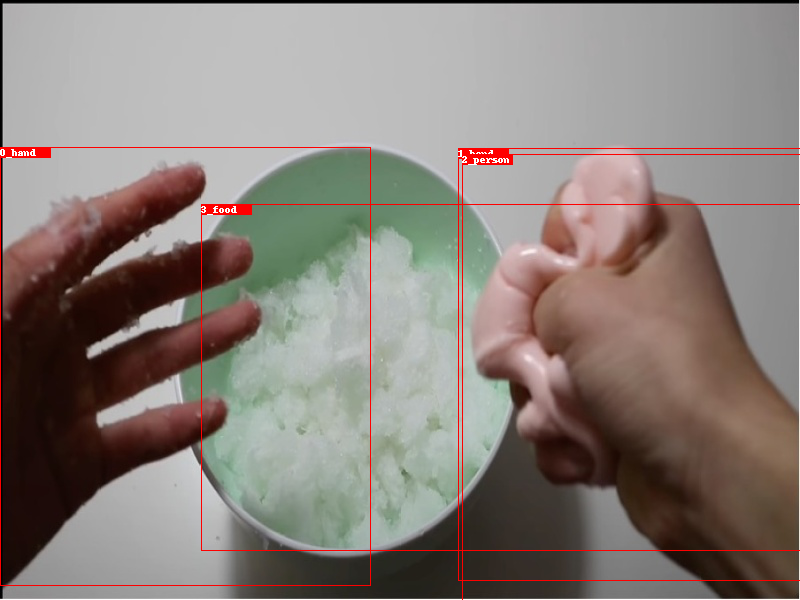

**************************************************
box_labels 0: hand; score: 0.88037109375
box_labels 1: hand; score: 0.8662109375
box_labels 2: person; score: 0.75634765625
box_labels 3: food; score: 0.07965087890625
**************************************************
rel_labels 0: 0_hand => holding => 3_food; score: 0.376220703125
rel_labels 1: 1_hand => holding => 3_food; score: 0.322509765625
rel_labels 2: 2_person => holding => 3_food; score: 0.2213134765625
rel_labels 3: 2_person => in => 0_hand; score: 0.2178955078125
rel_labels 4: 2_person => in => 1_hand; score: 0.20556640625
rel_labels 5: 3_food => in => 0_hand; score: 0.0648193359375
rel_labels 6: 3_food => in => 1_hand; score: 0.0570068359375
rel_labels 7: 1_hand => holding => 2_person; score: 0.02252197265625
rel_labels 8: 0_hand => holding => 2_person; score: 0.0184783935546875
rel_labels 9: 0_hand => in => 1_hand; score: 0.0097808837890625
rel_labels 10: 1_hand => in => 0_hand; score: 0.00959014892578125
rel_labels 11: 3

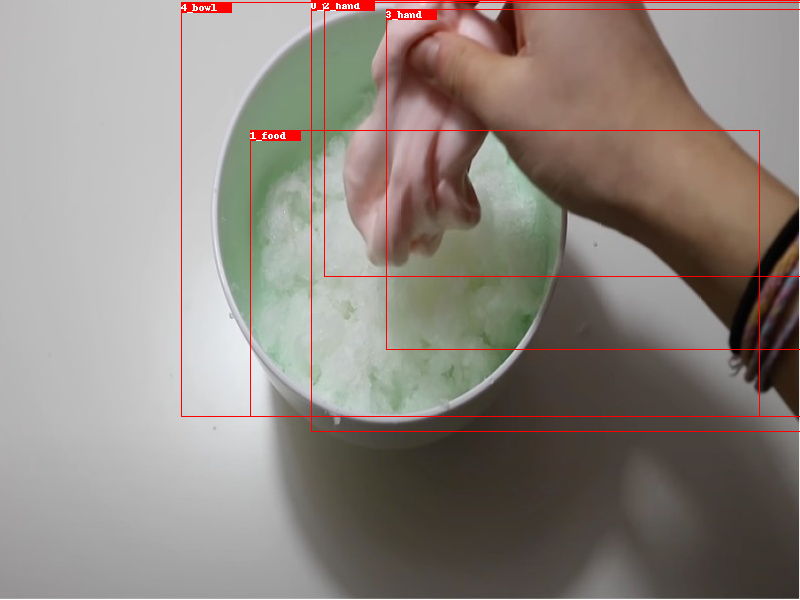

**************************************************
box_labels 0: person; score: 0.6416015625
box_labels 1: food; score: 0.55224609375
box_labels 2: hand; score: 0.37890625
box_labels 3: hand; score: 0.296630859375
box_labels 4: bowl; score: 0.1944580078125
**************************************************
rel_labels 0: 4_bowl => of => 1_food; score: 0.4306640625
rel_labels 1: 0_person => in => 3_hand; score: 0.2421875
rel_labels 2: 0_person => in => 2_hand; score: 0.1875
rel_labels 3: 0_person => in => 4_bowl; score: 0.1580810546875
rel_labels 4: 2_hand => holding => 4_bowl; score: 0.142578125
rel_labels 5: 3_hand => holding => 4_bowl; score: 0.11968994140625
rel_labels 6: 3_hand => holding => 1_food; score: 0.10308837890625
rel_labels 7: 1_food => in => 4_bowl; score: 0.061309814453125
rel_labels 8: 1_food => in => 3_hand; score: 0.05267333984375
rel_labels 9: 0_person => with => 1_food; score: 0.051513671875
rel_labels 10: 1_food => in => 2_hand; score: 0.031646728515625
rel_labels 

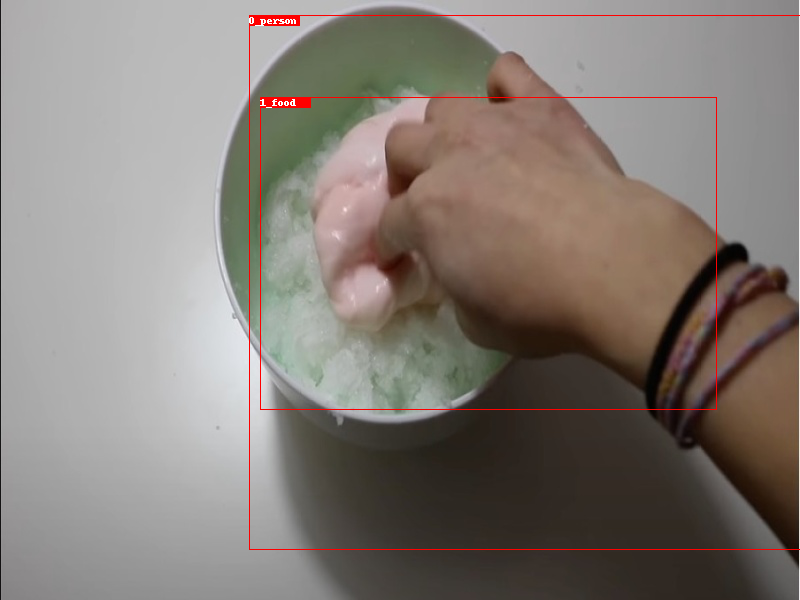

**************************************************
box_labels 0: person; score: 0.6240234375
box_labels 1: food; score: 0.330810546875
**************************************************
rel_labels 0: 0_person => holding => 1_food; score: 0.17626953125
rel_labels 1: 1_food => with => 0_person; score: 0.0023441314697265625
---kk.jpg------
==>  [91.0, 49.0, 49.0, 91.0, 3.0, 49.0]
with
with
holding
with
holding
of
of
with
of
of
of
on
of
with
in
with
with
of
of
on
with
in
in
with
with
with
with
in
with
with
draw info:  0_person
draw info:  1_food
draw info:  2_food
draw info:  3_person
draw info:  4_arm
draw info:  5_food


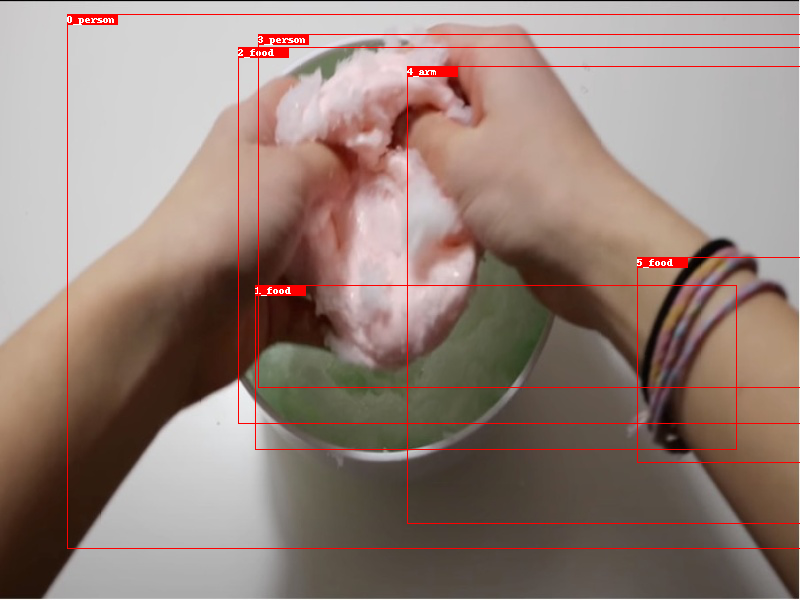

**************************************************
box_labels 0: person; score: 0.72314453125
box_labels 1: food; score: 0.482177734375
box_labels 2: food; score: 0.164306640625
box_labels 3: person; score: 0.0130157470703125
box_labels 4: arm; score: 0.0117645263671875
box_labels 5: food; score: 0.0025634765625
**************************************************
rel_labels 0: 0_person => with => 3_person; score: 0.2103271484375
rel_labels 1: 0_person => with => 4_arm; score: 0.1917724609375
rel_labels 2: 0_person => holding => 2_food; score: 0.1671142578125
rel_labels 3: 0_person => with => 5_food; score: 0.11993408203125
rel_labels 4: 0_person => holding => 1_food; score: 0.10894775390625
rel_labels 5: 4_arm => of => 1_food; score: 0.0882568359375
rel_labels 6: 4_arm => of => 3_person; score: 0.087646484375
rel_labels 7: 2_food => with => 3_person; score: 0.058624267578125
rel_labels 8: 4_arm => of => 2_food; score: 0.049163818359375
rel_labels 9: 3_person => of => 1_food; score: 0.04

In [108]:
img_paths =['l.jpg', 'k.jpg', 'j.jpg','i.jpg', 'h.jpg','g.jpg', 'f.jpg','e.jpg', 'd.jpg', 'c.jpg', 'b.jpg']#, 'g.jpg', 'h.jpg', 'i.jpg', 'j.jpg']
for image_idx, each_img_path in enumerate(TEST_IMAGE_PATHS):
    image_path = str(each_img_path)
    each_img = image_path.split('/')[-1]
    print("---{}------".format(each_img))
    image_path = "/hdd/skchoi/SGG_from_NLS/datasets/vg/VG_10/{}".format(each_img)
    boxes = custom_prediction[str(image_idx)]['bbox'][:box_topk]
    box_labels = custom_prediction[str(image_idx)]['bbox_labels'][:box_topk]
    box_scores = custom_prediction[str(image_idx)]['bbox_scores'][:box_topk]
    all_rel_labels = custom_prediction[str(image_idx)]['rel_labels']
    all_rel_scores = custom_prediction[str(image_idx)]['rel_scores']
    all_rel_pairs = custom_prediction[str(image_idx)]['rel_pairs']

    print("==> ", box_labels)
    for i in range(len(box_labels)):
        # print
        # print(type(box_labels[i]), box_labels[i])
        idx = str(int(box_labels[i]))
        box_labels[i] = ind_to_classes[idx]

    rel_labels = []
    rel_scores = []
    for i in range(len(all_rel_pairs)):
        if all_rel_pairs[i][0] < box_topk and all_rel_pairs[i][1] < box_topk:
            rel_scores.append(all_rel_scores[i])
            print(ind_to_predicates[str(all_rel_labels[i])] )#+ ' => ' + str(all_rel_pairs[i][1]) + '_' + box_labels[all_rel_pairs[i][1]])
            label = str(all_rel_pairs[i]
            [0]) + '_' + box_labels[all_rel_pairs[i][0]] + ' => ' + ind_to_predicates[str(all_rel_labels[i])]  + ' => ' + str(all_rel_pairs[i][1]) + '_' + box_labels[all_rel_pairs[i][1]]
            # label = box_labels[all_rel_pairs[i][0]] + ' => ' + ind_to_predicates[str(all_rel_labels[i])]  + ' => ' + box_labels[all_rel_pairs[i][1]]
            rel_labels.append(label)

    rel_labels = rel_labels[:rel_topk]
    rel_scores = rel_scores[:rel_topk]

    draw_image(image_path, boxes, box_labels, rel_labels, box_scores=box_scores, rel_scores=rel_scores)

In [ ]:
## Replace the top1_relation into detected relation from a transcript.
top1_rel = rel_labels[0]
top1_rel = top1_rel.replace(rel_labels[0].split("=>")[1], " " + predicates + " ")
print(top1_rel)

In [34]:
# !pip install tensorflow-object-detection-api
from object_detection.utils import visualization_utils as vis_util

## Scene Graph Parser

In [ ]:
!pip install SceneGraphParser

In [ ]:
!python -m spacy download en

In [18]:
import sng_parser

transcript_info = {"b": "while i'm waiting for my water to boil i'm going to go ahead and take out my eggs that way they can get a little bit room temperature and i always just make two soft boiled eggs for myself",
            "c": "it was we're going to turn this on like on a low heat",
            "d": "then we're just going to add our eggs into the water",
            "e": "and i am just going to crack it open and then i spoon it out",
            "f": "i went ahead and i turned it off the stove anyways",
            "g": "but i'm going to take these out real quick",
            "h": "so now i want to season them up so i'm just going to add a little bit of the lemon pepper",
            "i": "we are going to add just a tiny bit of salt",
            "j": "and then just a little bit of pepper and mix it up"}

transcripts = list(transcript_info.values())
graphs = []

for each in transcripts:
    graph = sng_parser.parse(each)
    graphs.append(graph)

assert len(transcript_info) == len(graphs)

In [22]:
import spacy

nlp = spacy.load("en_core_web_sm")
predicates_verb = []

for t, g in zip(transcripts, graphs):
  print("=="*20, "\n", t)
  doc = nlp(t)

  verbs = []
  for token in doc:
    if token.pos_ == "VERB":
      verbs.append(str(token))
      print('{} -> {}'.format(token, token.pos_))
  # print(verbs)
  predicates_verb.append(verbs)

  predicates = []
  # sng_parser.tprint(g)
  for rel in g['relations']:
    print(rel['relation'], ' in ', verbs)
    if rel['relation'] in verbs:
      predicates.append(rel['relation'])
  print(predicates)

 while i'm waiting for my water to boil i'm going to go ahead and take out my eggs that way they can get a little bit room temperature and i always just make two soft boiled eggs for myself
waiting -> VERB
boil -> VERB
going -> VERB
go -> VERB
take -> VERB
get -> VERB
make -> VERB
boiled -> VERB
get  in  ['waiting', 'boil', 'going', 'go', 'take', 'get', 'make', 'boiled']
make  in  ['waiting', 'boil', 'going', 'go', 'take', 'get', 'make', 'boiled']
for  in  ['waiting', 'boil', 'going', 'go', 'take', 'get', 'make', 'boiled']
['get', 'make']
 it was we're going to turn this on like on a low heat
going -> VERB
turn -> VERB
[]
 then we're just going to add our eggs into the water
going -> VERB
add -> VERB
[]
 and i am just going to crack it open and then i spoon it out
going -> VERB
crack -> VERB
spoon -> VERB
spoon  in  ['going', 'crack', 'spoon']
['spoon']
 i went ahead and i turned it off the stove anyways
went -> VERB
turned -> VERB
turned  in  ['went', 'turned']
off  in  ['went', 'turn

In [13]:
sng_parser.tprint(graph)

Entities:
+--------+----------------------------------+--------------------+
| Head   | Span                             | Modifiers          |
|--------+----------------------------------+--------------------|
| we     | we                               |                    |
| these  | these                            |                    |
| bowl   | our bowl                         |                    |
| we     | we                               |                    |
| cup    | 1/3 cup                          | 1/3                |
| sugar  | tightly packed light brown sugar | packed,light,brown |
+--------+----------------------------------+--------------------+
Relations:
+-----------+------------+----------+
| Subject   | Relation   | Object   |
|-----------+------------+----------|
| we        | add        | these    |
| we        | to         | bowl     |
| we        | add        | cup      |
| cup       | of         | sugar    |
+-----------+------------+----------+


In [83]:
graph['relations']

[{'subject': 0, 'object': 1, 'relation': 'add', 'lemma_relation': 'add'},
 {'subject': 0, 'object': 2, 'relation': 'to', 'lemma_relation': 'to'},
 {'subject': 3, 'object': 4, 'relation': 'add', 'lemma_relation': 'add'},
 {'subject': 4, 'object': 5, 'relation': 'of', 'lemma_relation': 'of'}]

In [23]:
predicates_verb

[['waiting', 'boil', 'going', 'go', 'take', 'get', 'make', 'boiled'],
 ['going', 'turn'],
 ['going', 'add'],
 ['going', 'crack', 'spoon'],
 ['went', 'turned'],
 ['going', 'take'],
 ['want', 'season', 'going', 'add'],
 ['going', 'add'],
 ['mix']]